# 1.Load dataset

In [1]:
! gdown --id 1GaTMURqIQTjtalbNVAyVgPIEis21A0r8

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1GaTMURqIQTjtalbNVAyVgPIEis21A0r8
From (redirected): https://drive.google.com/uc?id=1GaTMURqIQTjtalbNVAyVgPIEis21A0r8&confirm=t&uuid=c605c4b6-a984-4cf4-8850-cfc4c0668e93
To: /content/FER-2013.zip
100% 63.3M/63.3M [00:01<00:00, 40.8MB/s]


In [2]:
! unzip -q '/content/FER-2013.zip'

# 2.Import neccessary libraries

In [3]:
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Resize
from torchvision.io import read_image

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 3.Set a fix random state

In [4]:
random_state = 59
np.random.seed(random_state)
torch.manual_seed(random_state)

if torch.cuda.is_available():
    torch.cuda.manual_seed(random_state)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# 4.Read number of classes in dataset

In [5]:
train_dir = '/content/train'
test_dir = '/content/test'

classes = os.listdir(train_dir)
num_classes = len(classes)

print(f'Number of classes: {num_classes}')

label2idx = {cls:idx for idx, cls in enumerate(classes)}
idx2label = {idx:cls for idx, cls in enumerate(classes)}

print(label2idx)
print(idx2label)

Number of classes: 7
{'surprise': 0, 'sad': 1, 'fear': 2, 'neutral': 3, 'angry': 4, 'happy': 5, 'disgust': 6}
{0: 'surprise', 1: 'sad', 2: 'fear', 3: 'neutral', 4: 'angry', 5: 'happy', 6: 'disgust'}


# 5.Build DataLoader

In [6]:
test_img_path = '/content/train/angry/Training_10118481.jpg'
img = cv2.imread(test_img_path)
img_height, img_width = (128, 128)

print(f'Image height: {img_height}')
print(f'Image width: {img_width}')

class Image_Dataset(Dataset):
    def __init__(self, img_dir, norm, label2idx, split='train', train_ratio=0.8):
        self.resize = Resize((img_height, img_width))
        self.img_dir = img_dir
        self.norm = norm
        self.label2idx = label2idx
        self.split = split
        self.train_ratio = train_ratio

        self.img_paths, self.img_labels = self.read_img_files()

        if split in ['train', 'val'] and 'train' in img_dir.lower():
            train_data, val_data = train_test_split(
                list(zip(self.img_paths, self.img_labels)),
                train_size=self.train_ratio,
                random_state=random_state,
                stratify=self.img_labels
            )

            if split == 'train':
                self.img_paths, self.img_labels = zip(*train_data)
            else:
                self.img_paths, self.img_labels = zip(*val_data)

    def read_img_files(self):
        img_paths = []
        img_labels = []

        for cls in self.label2idx.keys():
            for img in os.listdir(os.path.join(self.img_dir, cls)):
                img_paths.append(os.path.join(self.img_dir, cls, img))
                img_labels.append(cls)

        return img_paths, img_labels

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        cls = self.img_labels[idx]
        img = self.resize(read_image(img_path))
        img = img.type(torch.float32)
        label = self.label2idx[cls]

        if self.norm:
            img = (img/127.5) - 1

        return img, label

Image height: 128
Image width: 128


In [7]:
batch_size = 256

train_dataset = Image_Dataset(img_dir=train_dir, norm=True, label2idx=label2idx, split='train')
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = Image_Dataset(img_dir=train_dir, norm=True, label2idx=label2idx, split='val')
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

test_dataset = Image_Dataset(img_dir=test_dir, norm=True, label2idx=label2idx, split='test')
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

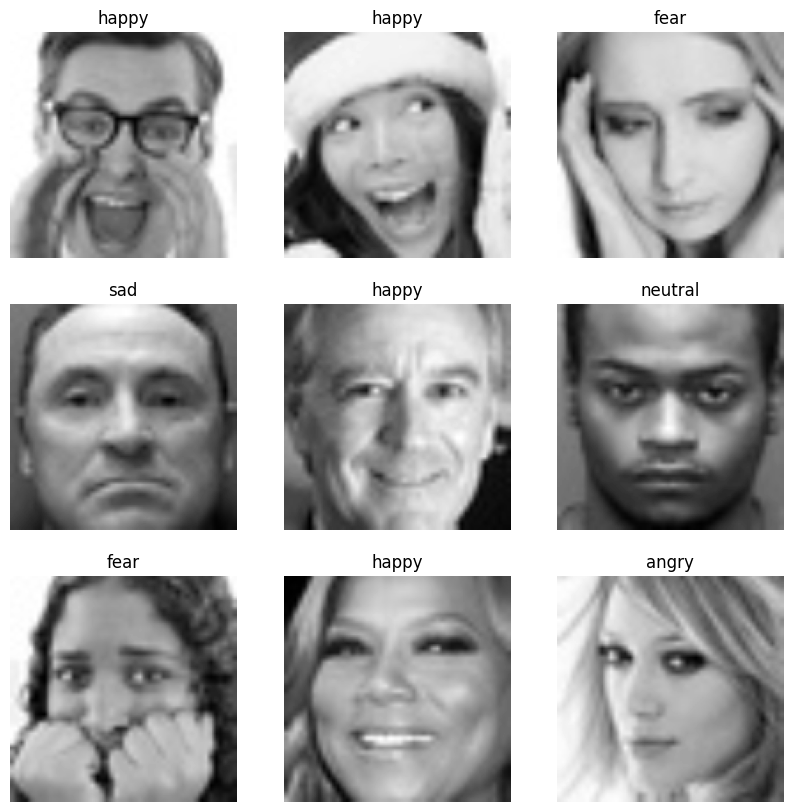

In [9]:
image_patch, label_patch = next(iter(train_loader))

plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    minv = image_patch[i].numpy().min()
    maxv = image_patch[i].numpy().max()
    plt.imshow(np.squeeze(image_patch[i].numpy()), cmap='gray', vmin=minv, vmax=maxv)
    label = label_patch[i]
    plt.title(idx2label[label.item()])
    plt.axis('off')

# 6.Construct MLPs network

In [10]:
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(input_dims, hidden_dims*4)
        self.linear2 = nn.Linear(hidden_dims*4, hidden_dims*2)
        self.linear3 = nn.Linear(hidden_dims*2, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)

    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        x = self.linear3(x)
        x = F.relu(x)
        out = self.output(x)
        return out.squeeze(1)

In [11]:
input_dims = img_height * img_width
output_dims = len(classes)
hidden_dims = 64
lr = 1e-2

model = MLP(input_dims=input_dims, hidden_dims=hidden_dims, output_dims=output_dims).to(device)

# 7.Declare loss and optimizer functions

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

# 8.Build accuracy function

In [13]:
def compute_accuracy(y_hat, y_true):
    _, y_hat = torch.max(y_hat, dim=1)
    correct = (y_hat == y_true).sum().item()
    accuracy = correct / len(y_true)
    return accuracy

# 9.Train the MLP model

In [14]:
epochs = 40
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(epochs):
    train_loss = 0.0
    train_target = []
    train_predict = []

    model.train()

    for X_samples, y_samples in train_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)

        optimizer.zero_grad()
        outputs = model(X_samples)
        loss = criterion(outputs, y_samples)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        train_predict.append(outputs.detach().cpu())
        train_target.append(y_samples.cpu())

    train_loss = train_loss / len(train_loader)
    train_losses.append(train_loss)

    train_predict = torch.cat(train_predict)
    train_target = torch.cat(train_target)
    train_acc = compute_accuracy(train_predict, train_target)
    train_accs.append(train_acc)

    val_loss = 0.0
    val_target = []
    val_predict = []
    model.eval()

    with torch.no_grad():
        for X_samples, y_samples in val_loader:
            X_samples = X_samples.to(device)
            y_samples = y_samples.to(device)
            outputs = model(X_samples)

            loss = criterion(outputs, y_samples)
            val_loss += loss.item()

            val_predict.append(outputs.cpu())
            val_target.append(y_samples.cpu())

    val_predict = torch.cat(val_predict)
    val_target = torch.cat(val_target)
    val_acc = compute_accuracy(val_predict, val_target)
    val_accs.append(val_acc)


    val_loss = val_loss / len(val_loader)
    val_losses.append(val_loss)

    print(f'\nEPOCH {epoch+1}:\tTraining loss: {train_loss:.3f}\tValidation loss: {val_loss:.3f}')


EPOCH 1:	Training loss: 1.907	Validation loss: 1.868

EPOCH 2:	Training loss: 1.837	Validation loss: 1.820

EPOCH 3:	Training loss: 1.804	Validation loss: 1.799

EPOCH 4:	Training loss: 1.785	Validation loss: 1.783

EPOCH 5:	Training loss: 1.770	Validation loss: 1.768

EPOCH 6:	Training loss: 1.753	Validation loss: 1.751

EPOCH 7:	Training loss: 1.734	Validation loss: 1.731

EPOCH 8:	Training loss: 1.713	Validation loss: 1.710

EPOCH 9:	Training loss: 1.692	Validation loss: 1.690

EPOCH 10:	Training loss: 1.672	Validation loss: 1.671

EPOCH 11:	Training loss: 1.655	Validation loss: 1.657

EPOCH 12:	Training loss: 1.641	Validation loss: 1.648

EPOCH 13:	Training loss: 1.631	Validation loss: 1.638

EPOCH 14:	Training loss: 1.620	Validation loss: 1.631

EPOCH 15:	Training loss: 1.611	Validation loss: 1.625

EPOCH 16:	Training loss: 1.602	Validation loss: 1.619

EPOCH 17:	Training loss: 1.594	Validation loss: 1.613

EPOCH 18:	Training loss: 1.585	Validation loss: 1.609

EPOCH 19:	Training

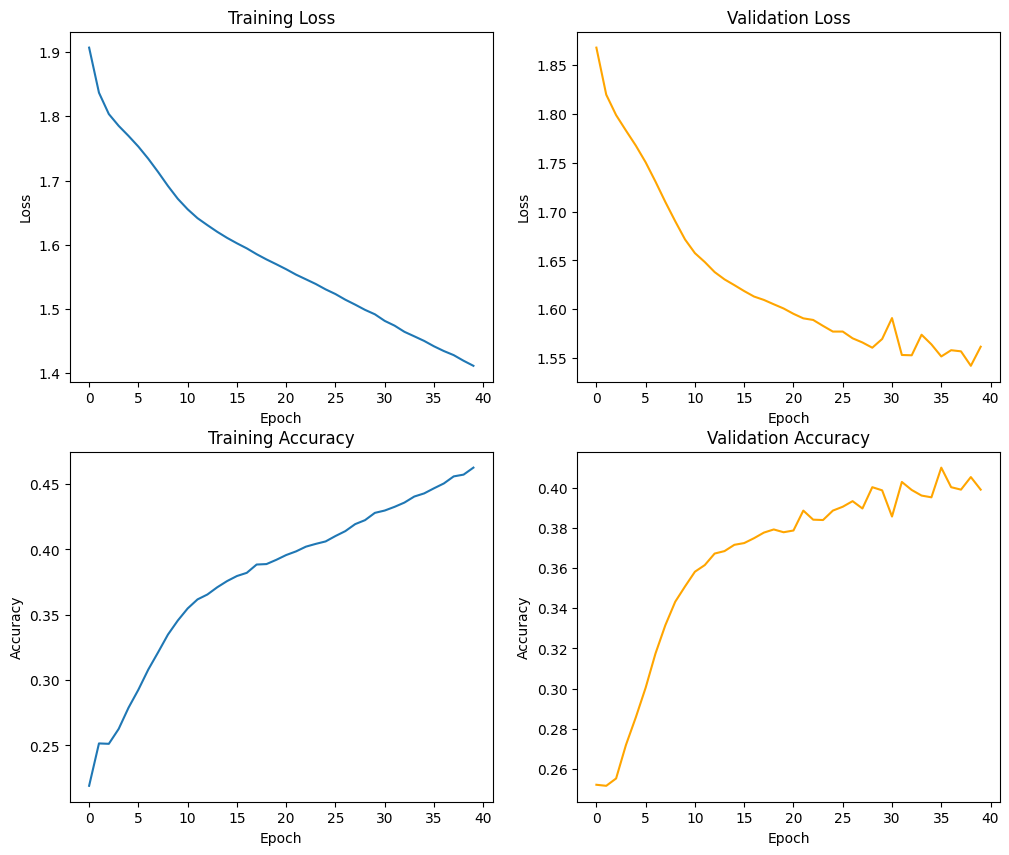

In [15]:
# data visualization
fig, ax = plt.subplots(2, 2, figsize = (12,10))

ax[0,0].plot(train_losses)
ax[0,0].set(xlabel='Epoch', ylabel='Loss')
ax[0,0].set_title('Training Loss')

ax[0,1].plot(val_losses, 'orange')
ax[0,1].set(xlabel='Epoch', ylabel='Loss')
ax[0,1].set_title('Validation Loss')

ax[1,0].plot(train_accs)
ax[1,0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1,0].set_title('Training Accuracy')

ax[1,1].plot(val_accs, 'orange')
ax[1,1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1,1].set_title('Validation Accuracy')

plt.show()

# 10.Evaluate model on test dataset

In [16]:
test_target = []
test_predict = []
model.eval()

with torch.no_grad():
    for X_samples, y_samples in test_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        outputs = model(X_samples)

        test_predict.append(outputs.cpu())
        test_target.append(y_samples.cpu())

    test_predict = torch.cat(test_predict)
    test_target = torch.cat(test_target)
    test_acc = compute_accuracy(test_predict, test_target)

    print('Evaluation on test set :')
    print(f'Test Accuracy: {test_acc}')

Evaluation on test set :
Test Accuracy: 0.40192254109779885
